In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv("accident.csv")

In [3]:
print(df.head())

   Age  Gender  Speed_of_Impact Helmet_Used Seatbelt_Used  Survived
0   56  Female             27.0          No            No         1
1   69  Female             46.0          No           Yes         1
2   46    Male             46.0         Yes           Yes         0
3   32    Male            117.0          No           Yes         0
4   60  Female             40.0         Yes           Yes         0


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              200 non-null    int64  
 1   Gender           199 non-null    object 
 2   Speed_of_Impact  197 non-null    float64
 3   Helmet_Used      200 non-null    object 
 4   Seatbelt_Used    200 non-null    object 
 5   Survived         200 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 9.5+ KB
None


In [5]:
print(df.isnull().sum())

Age                0
Gender             1
Speed_of_Impact    3
Helmet_Used        0
Seatbelt_Used      0
Survived           0
dtype: int64


In [6]:
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 0


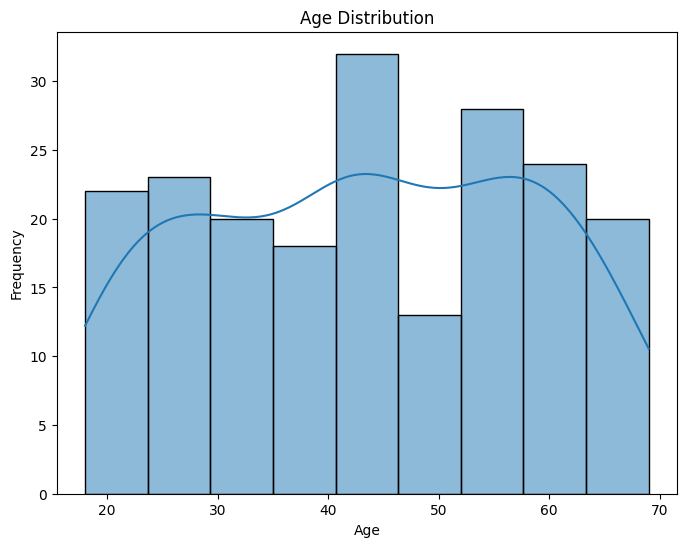

In [7]:
plt.figure(figsize=(8,6))
sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

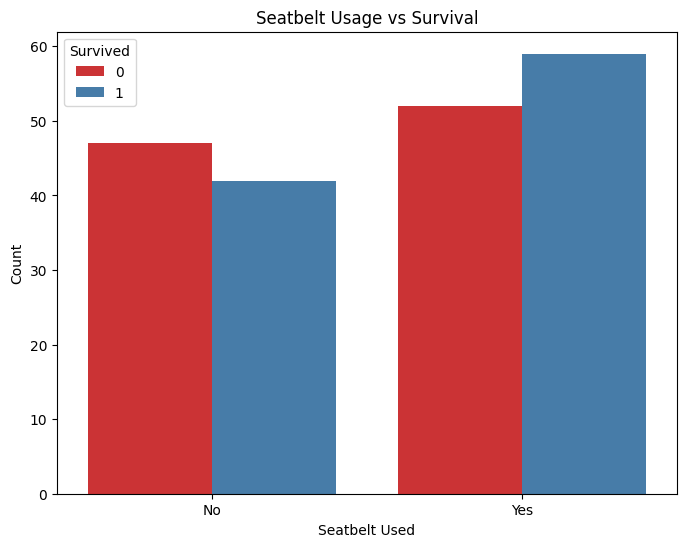

In [8]:
plt.figure(figsize=(8,6))
sns.countplot(x='Seatbelt_Used', hue='Survived', data=df, palette='Set1')
plt.title('Seatbelt Usage vs Survival')
plt.xlabel('Seatbelt Used')
plt.ylabel('Count')
plt.show()

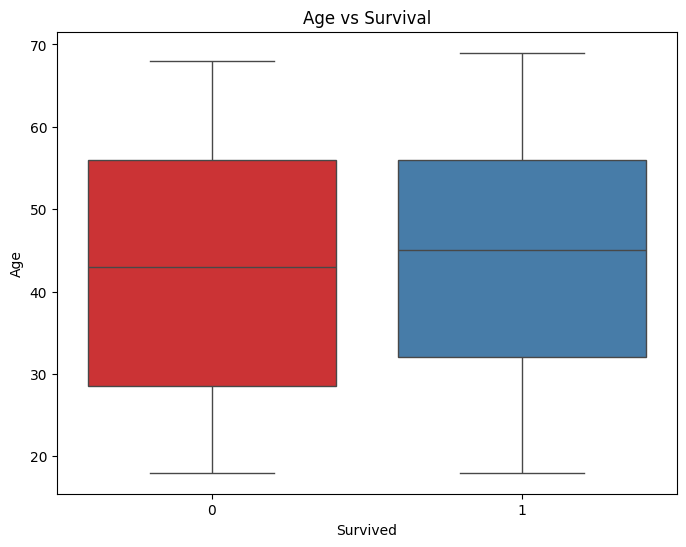

In [9]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Survived', y='Age', data=df, palette='Set1')
plt.title('Age vs Survival')
plt.xlabel('Survived')
plt.ylabel('Age')
plt.show()

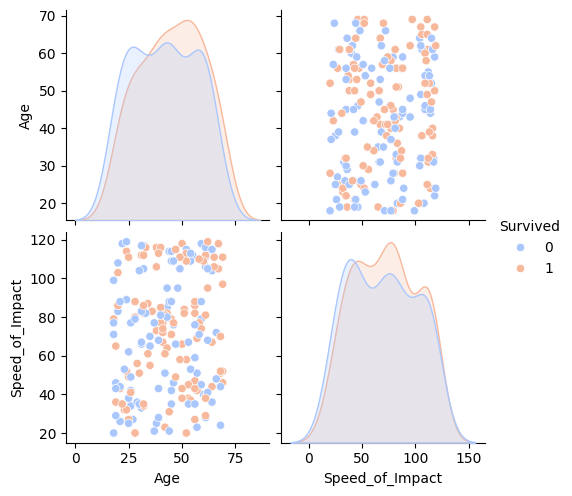

In [10]:
sns.pairplot(df, hue='Survived', palette='coolwarm')
plt.show()

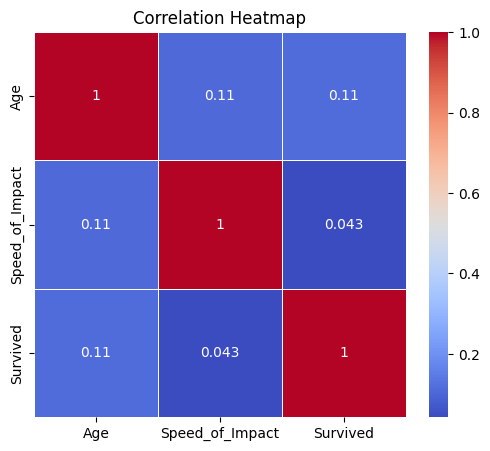

In [11]:
correlation_matrix = df[['Age', 'Speed_of_Impact', 'Survived']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

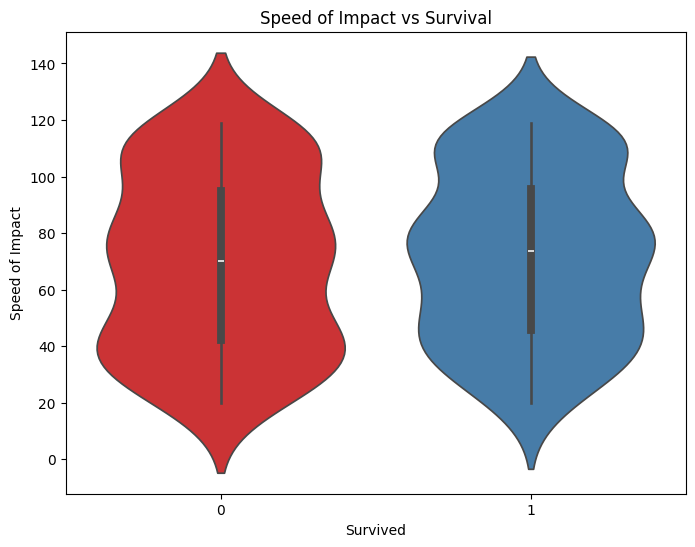

In [12]:
plt.figure(figsize=(8,6))
sns.violinplot(x='Survived', y='Speed_of_Impact', data=df, palette='Set1')
plt.title('Speed of Impact vs Survival')
plt.xlabel('Survived')
plt.ylabel('Speed of Impact')
plt.show()

In [25]:
df.fillna(df.mode().iloc[0], inplace=True)

In [26]:
label_cols = ["Gender", "Helmet_Used", "Seatbelt_Used"]
encoder = LabelEncoder()
for col in label_cols:
    df[col] = encoder.fit_transform(df[col])

In [27]:
X = df.drop("Survived", axis=1)
y = df["Survived"]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [29]:
param_grids = {
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear']
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5]
    }
}

In [30]:
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(),
    "Naive Bayes": GaussianNB()
}

In [31]:
results = {}
best_models = {}

for name, model in models.items():
    if name in param_grids:
        grid = GridSearchCV(model, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_params = grid.best_params_
    else:
        best_model = model
        best_model.fit(X_train, y_train)
        best_params = best_model.get_params()

    y_pred = best_model.predict(X_test)

    results[name] = {
        "Accuracy": round(accuracy_score(y_test, y_pred), 3),
        "Precision": round(precision_score(y_test, y_pred, average='weighted'), 3),
        "Recall": round(recall_score(y_test, y_pred, average='weighted'), 3),
        "F1 Score": round(f1_score(y_test, y_pred, average='weighted'), 3)
    }
    best_models[name] = best_model.get_params() 

In [32]:
with open('results.json', 'w') as f:
    json.dump(results, f, indent=4)

with open("best_models.json", "w") as file:
    json.dump(best_models, file, indent=4)

results_df = pd.DataFrame(results).T
print("\nPerformance Summary:")
print(results_df)

best_model_name = results_df["Accuracy"].idxmax()
print(f"\nBest Model: {best_model_name} with Accuracy {results_df.loc[best_model_name, 'Accuracy']:.3f}")


Performance Summary:
                        Accuracy  Precision  Recall  F1 Score
Logistic Regression        0.567      0.563   0.567     0.564
K-Nearest Neighbors        0.500      0.513   0.500     0.502
Decision Tree              0.467      0.492   0.467     0.460
Random Forest              0.533      0.553   0.533     0.533
Gradient Boosting          0.533      0.542   0.533     0.535
Support Vector Machine     0.467      0.761   0.467     0.331
Naive Bayes                0.500      0.485   0.500     0.488

Best Model: Logistic Regression with Accuracy 0.567


In [ ]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Define models (without hyperparameter tuning)
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(),
    "Naive Bayes": GaussianNB()
}

# Define hyperparameter grids for tuning
param_grids = {
    "Logistic Regression": {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
        'penalty': ['l1', 'l2'],  # Lasso or Ridge
        'solver': ['liblinear', 'saga']  # Solvers supporting L1/L2
    },
    
    "K-Nearest Neighbors": {
        'n_neighbors': [3, 5, 7, 10, 15, 20],  # Number of neighbors
        'weights': ['uniform', 'distance'],  # Weighting method
        'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric
    },

    "Decision Tree": {
        'criterion': ['gini', 'entropy'],  # Splitting criterion
        'max_depth': [3, 5, 10, 20, None],  # Tree depth
        'min_samples_split': [2, 5, 10],  # Minimum samples required to split
        'min_samples_leaf': [1, 2, 5]  # Minimum samples per leaf node
    },

    "Random Forest": {
        'n_estimators': [50, 100, 200, 300],  # Number of trees
        'max_depth': [3, 5, 10, 20, None],  # Tree depth
        'criterion': ['gini', 'entropy'],  # Splitting criterion
        'min_samples_split': [2, 5, 10],  # Min samples required to split
        'min_samples_leaf': [1, 2, 5],  # Min samples per leaf
        'bootstrap': [True, False]  # Whether to bootstrap samples
    },

    "Gradient Boosting": {
        'n_estimators': [50, 100, 200, 300],  # Number of boosting stages
        'learning_rate': [0.001, 0.01, 0.1, 0.2],  # Step size shrinkage
        'max_depth': [3, 5, 10],  # Tree depth
        'min_samples_split': [2, 5, 10],  # Min samples required to split
        'min_samples_leaf': [1, 2, 5],  # Min samples per leaf
        'subsample': [0.8, 1.0]  # Fraction of samples per boosting iteration
    },

    "Support Vector Machine": {
        'C': [0.1, 1, 10, 100],  # Regularization strength
        'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
        'gamma': ['scale', 'auto'],  # Kernel coefficient
        'degree': [2, 3, 4]  # Degree for polynomial kernel
    },

    "Naive Bayes": {  
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]  # Variance smoothing for GaussianNB
    },

    "XGBoost": {
        'n_estimators': [50, 100, 200, 300],  # Number of boosting rounds
        'learning_rate': [0.001, 0.01, 0.1, 0.2],  # Step size shrinkage
        'max_depth': [3, 5, 10],  # Tree depth
        'subsample': [0.8, 1.0],  # Fraction of samples per boosting iteration
        'colsample_bytree': [0.8, 1.0]  # Fraction of features used per tree
    }
}

# Store results
results_no_tuning = {}  # Table 1: Results without tuning
results_tuned = {}      # Table 2: Results with tuning
best_hyperparameters = {}

# Run models without tuning (Table 1)
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results_no_tuning[name] = {
        "Accuracy": round(accuracy_score(y_test, y_pred), 3),
        "Precision": round(precision_score(y_test, y_pred, average='weighted'), 3),
        "Recall": round(recall_score(y_test, y_pred, average='weighted'), 3),
        "F1 Score": round(f1_score(y_test, y_pred, average='weighted'), 3)
    }

# Run models with hyperparameter tuning (Table 2)
for name, model in models.items():
    if name in param_grids:
        grid = GridSearchCV(model, param_grids[name], cv=10, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_params = grid.best_params_
    else:
        best_model = model
        best_model.fit(X_train, y_train)
        best_params = best_model.get_params()  # Get parameters of non-tuned models

    # Perform 10-Fold Cross Validation
    scores = cross_val_score(best_model, X_train, y_train, cv=10, scoring='accuracy')
    avg_accuracy = scores.mean()

    y_pred = best_model.predict(X_test)

    results_tuned[name] = {
        "Accuracy": round(accuracy_score(y_test, y_pred), 3),
        "Precision": round(precision_score(y_test, y_pred, average='weighted'), 3),
        "Recall": round(recall_score(y_test, y_pred, average='weighted'), 3),
        "F1 Score": round(f1_score(y_test, y_pred, average='weighted'), 3),
        "Cross-Validation Accuracy (10-Fold)": round(avg_accuracy, 3)
    }

    # Store best hyperparameters
    best_hyperparameters[name] = {key: value for key, value in best_params.items()}

# Save results to JSON files
with open("results_no_tuning.json", "w") as f:
    json.dump(results_no_tuning, f, indent=4)

with open("results_tuned.json", "w") as f:
    json.dump(results_tuned, f, indent=4)

with open("best_hyperparameters.json", "w") as f:
    json.dump(best_hyperparameters, f, indent=4)

# Print summary
print("\nResults Without Hyperparameter Tuning:")
print(pd.DataFrame(results_no_tuning).T)

print("\nResults With Hyperparameter Tuning (10-Fold CV):")
print(pd.DataFrame(results_tuned).T)

print("\nBest Hyperparameters:")
print(json.dumps(best_hyperparameters, indent=4))


/home/prabhuji/dev/labs/ad/report/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/prabhuji/dev/labs/ad/report/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/prabhuji/dev/labs/ad/report/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/prabhuji/dev/labs/ad/report/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/prabhuji/dev/labs/ad/report/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  